In [75]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
import ast

In [76]:
df = pd.read_csv('results/auc_analysis.csv')

In [77]:
df.iloc[0].ratio

'(1, 1)'

In [78]:
df.head(100)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50
0,normal,2,"(0, 1)","(1, 1)",1.000000e-05,0.548379,0.009424,0.779106,0.014507,0.841485,0.002376,0.804916,0.004259,0.747296,0.016494,0.823602,0.010867
1,normal,2,"(0, 1)","(1, 1)",1.000000e-06,0.534905,0.008606,0.795636,0.000184,0.811800,0.000345,0.826421,0.000126,0.823367,0.000179,0.832691,0.000167
2,normal,2,"(0, 1)","(1, 1)",5.000000e-07,0.527536,0.008331,0.773339,0.000140,0.788750,0.000204,0.801248,0.000141,0.808881,0.000074,0.810469,0.000054
3,normal,2,"(0, 1)","(1, 1)",1.000000e-07,0.511716,0.005766,0.695252,0.000217,0.737971,0.000105,0.757464,0.000107,0.768312,0.000060,0.776103,0.000056
4,normal,2,"(0, 1)","(1, 1)",1.000000e-08,0.514619,0.003869,0.539653,0.009934,0.561937,0.008381,0.582308,0.007011,0.600090,0.006014,0.615487,0.005113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,both_sampled,3,"(0, 3, 1)","(20, 2, 1)",1.000000e-05,0.482321,0.001981,0.638496,0.003346,0.664763,0.006144,0.688224,0.004376,0.723593,0.002938,0.689425,0.002700
96,both_sampled,3,"(0, 3, 1)","(20, 2, 1)",1.000000e-06,0.510286,0.000414,0.698547,0.000375,0.711639,0.000236,0.712339,0.000351,0.708280,0.000682,0.717251,0.000264
97,both_sampled,3,"(0, 3, 1)","(20, 2, 1)",5.000000e-07,0.491123,0.002208,0.684412,0.000210,0.699318,0.000152,0.705136,0.000089,0.705225,0.000150,0.713374,0.000104
98,both_sampled,3,"(0, 3, 1)","(20, 2, 1)",1.000000e-07,0.486093,0.002111,0.583949,0.000822,0.631849,0.000283,0.652584,0.000215,0.666841,0.000151,0.674424,0.000104


In [79]:
df.ratio = df.ratio.apply(lambda x : ast.literal_eval(x))
df.classes_used = df.classes_used.apply(lambda x : ast.literal_eval(x))

In [80]:
# To-do: 
# loss + gradient descent 
# effective # of samples - implement 
# smote - implement 
# try new plots - best lr? 
# retrain w/ new learning rates 
# 2 class normal - 1e-05 - 1e-06

# Done:
# 10 : 1 
# focal loss - read + implement (need to check if it works)



ratio = (100, 1)

NUM_CLASSES=2

normal_df = df.loc[(df.name=='normal') & (df.num_classes==NUM_CLASSES)]
ratio_df = df.loc[(df.name=='ratio') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
oversampled_df = df.loc[(df.name=='oversampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
weighted_df = df.loc[(df.name=='weighted') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
undersampled_df = df.loc[(df.name=='undersampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
bothsampled_df = df.loc[(df.name=='both_sampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]

In [81]:
weighted_df.head(10)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50
50,weighted,2,"(0, 1)","(100, 1)",1.000000e-05,0.548379,0.009424,0.705224,0.006322,0.719227,0.003053,0.692638,0.002961,0.683244,0.002862,0.694694,0.001923
51,weighted,2,"(0, 1)","(100, 1)",1.000000e-06,0.534905,0.008606,0.799263,0.004559,0.810738,0.000798,0.823757,0.000192,0.824270,0.000030,0.821001,0.000095
52,weighted,2,"(0, 1)","(100, 1)",5.000000e-07,0.527536,0.008331,0.760206,0.002216,0.779845,0.000442,0.796304,0.000275,0.791114,0.000428,0.800013,0.000264
53,weighted,2,"(0, 1)","(100, 1)",1.000000e-07,0.511716,0.005766,0.687535,0.000949,0.724008,0.000250,0.727533,0.000350,0.741630,0.000171,0.748629,0.000196
54,weighted,2,"(0, 1)","(100, 1)",1.000000e-08,0.514619,0.003869,0.538144,0.009743,0.559358,0.008715,0.577911,0.007555,0.595342,0.006466,0.608298,0.005704


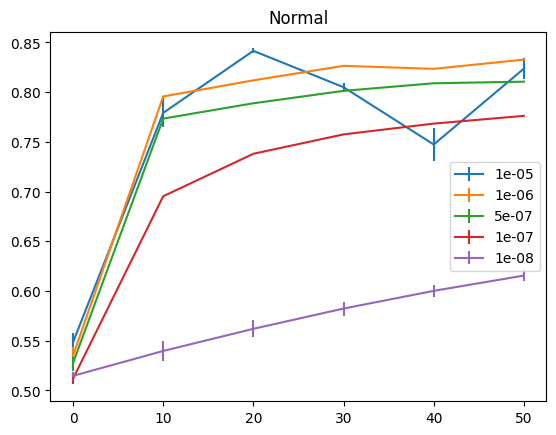

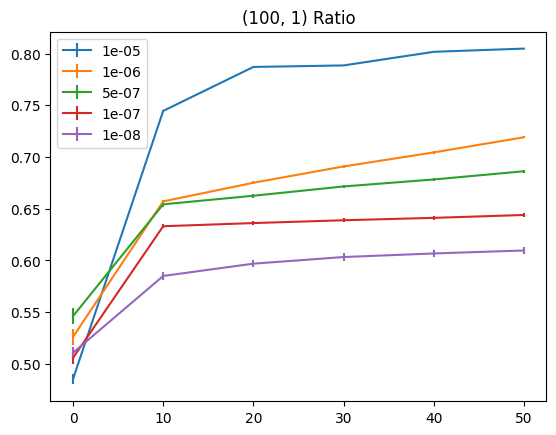

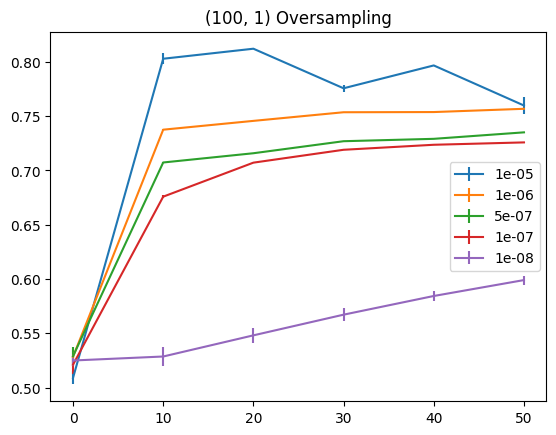

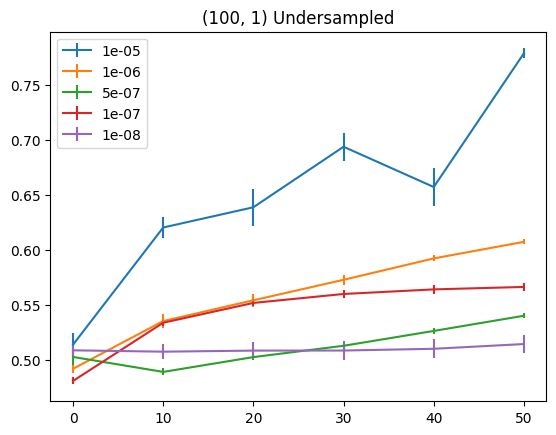

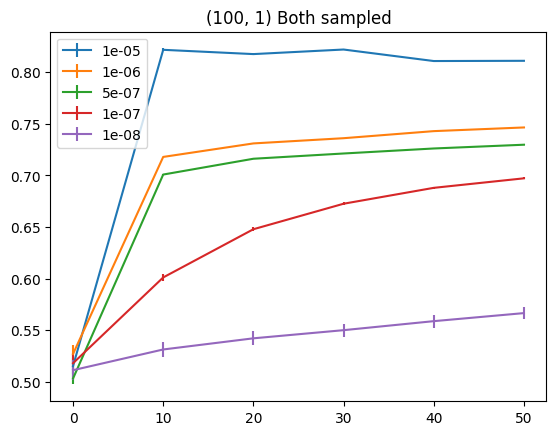

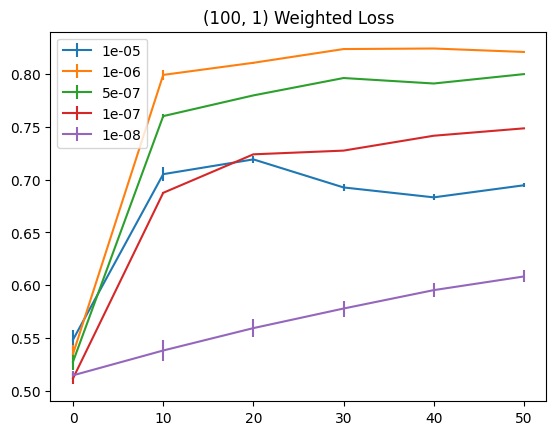

In [82]:
best_lrs={}

epochs = [0, 10, 20, 30, 40, 50]
mean_cols = ["mean_" + str(epoch )for epoch in epochs]
variance_cols = ["variance_" + str(epoch )for epoch in epochs]


best_mean=0
for index, row in normal_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title("Normal")
plt.legend()
plt.show()

best_mean=0
for index, row in ratio_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Ratio")
plt.legend()
plt.show()

best_mean=0
for index, row in oversampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Oversampling")
plt.legend()
plt.show()

best_mean=0
for index, row in undersampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Undersampled")
plt.legend()
plt.show()


best_mean=0
for index, row in bothsampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Both sampled")
plt.legend()
plt.show()

best_mean=0
for index, row in weighted_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Weighted Loss")
plt.legend()
plt.show()



In [83]:
print(best_lrs)

{'normal': 1e-06, 'ratio': 1e-05, 'oversampled': 1e-05, 'undersampled': 1e-05, 'both_sampled': 1e-05, 'weighted': 1e-06}


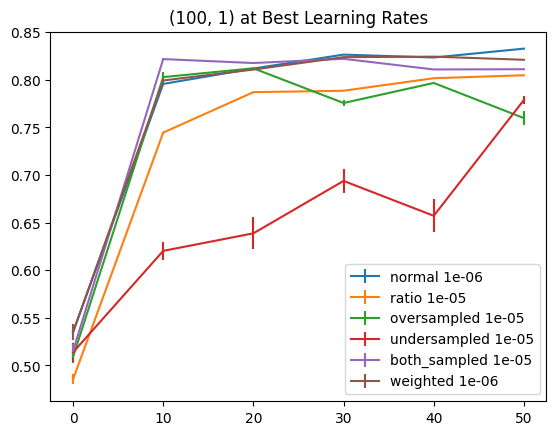

In [84]:
for key in best_lrs:
    means = []
    variances = []
    for epoch in epochs: 
        mean = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['mean_' + str(epoch)].iloc[0]

        var = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['variance_' + str(epoch)].iloc[0]
        means.append(mean)
        variances.append(var)
    plt.errorbar(epochs, means, yerr=variances, label=key + " " + str(best_lrs[key]))
plt.title(str(row['ratio']) + " at Best Learning Rates")
plt.legend()
plt.show()
# 3 class results for each class